# Obtener Datos

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
!wget https://www.dropbox.com/s/qii26wuxcbxw169/images.npy
!wget https://www.dropbox.com/s/gstpamhin8rlhlg/masks.npy

--2022-05-18 15:14:17--  https://www.dropbox.com/s/qii26wuxcbxw169/images.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qii26wuxcbxw169/images.npy [following]
--2022-05-18 15:14:17--  https://www.dropbox.com/s/raw/qii26wuxcbxw169/images.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucca69520925c615ff2dddfba9c7.dl.dropboxusercontent.com/cd/0/inline/BlgXg9Oa89H1r3E_o19fFARfbYmG40WQr_ii4M6ZZhUNNRmkW_DEOyh7Hb5YvuFRa_WpSENOQOh_S9JCGZXYBRXYVCgw7HQk_EobLQufGU-Xx6kzphzL_jwebThstWAbfkOYrGAFMKH-TnleQd-ePiyK_jwj80MyY5pmNsOCwMUqLQ/file# [following]
--2022-05-18 15:14:17--  https://ucca69520925c615ff2dddfba9c7.dl.dropboxusercontent.com/cd/0/inline/BlgXg9Oa89H1r3E_o19fFARfbYmG40WQr_ii4M6ZZhUNNRmkW_DEOyh7Hb5YvuFRa_WpSEN

In [ ]:
images = torch.from_numpy(np.load('images.npy'))
images=images[:,0:512,0:512,:]
masks = torch.from_numpy(np.load('masks.npy'))
masks=masks[:,0:512,0:512]
masks[masks==255] = 1

In [ ]:
dataset = [{'image': torch.reshape(image,(3,512,512)), 'label':torch.unsqueeze(mask, dim=0)} for image,mask in zip(images,masks)]

# Transformaciones 

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 821 kB 5.7 MB/s 


In [ ]:
import os
import tempfile
import numpy as np
from monai.apps import DecathlonDataset
from monai.utils import first
from monai.data import DataLoader, decollate_batch, CacheDataset
import matplotlib.pyplot as plt
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    # AsDiscreted,
    Compose,
    # Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    SaveImage,
)
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
import torch
import torch.nn as nn
from monai.networks.blocks.convolutions import Convolution
from monai.networks.layers import Norm

In [ ]:
train_transform = Compose([
  Spacingd(
    keys=["image", "label"],
    pixdim=(1.0, 1.0, 1.0),
    mode=("bilinear", "nearest"),
  ),
  #RandSpatialCropd(keys=["image", "label"], roi_size=[512, 512], random_size=False), # cambiar roi?
  #RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
  #RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
  NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
  RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
  RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
  EnsureTyped(keys=["image", "label"]),
])

val_transform = Compose([
  Spacingd(
    keys=["image", "label"],
    pixdim=(1.0, 1.0, 1.0),
    mode=("bilinear", "nearest"),
  ),
  NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
  EnsureTyped(keys=["image", "label"]),
])

In [ ]:
train_dataset = CacheDataset(data=dataset, transform=train_transform, cache_rate=1.0, num_workers=2)
train_loader = DataLoader(train_dataset, batch_size=4, num_workers=2)

val_dataset = CacheDataset(data=dataset[:1], transform=val_transform, cache_rate=1.0, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, num_workers=2)

Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


# Modelo

In [ ]:
from monai.networks.layers import Norm
from monai.networks.blocks.convolutions import Convolution

import torch.nn as nn

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 1000

In [ ]:
def simple_block(inc, out, kernel):
  block = Convolution(
      spatial_dims = 2,
      in_channels = inc,
      out_channels = out,
      kernel_size = kernel,
      norm = Norm.BATCH,
      act = 'ReLU',
      adn_ordering = 'AND' # Orden de las operaciones (no usamos dropout)
  )
  return block

def shortcut(inc, out):
  block = Convolution(
      spatial_dims = 2,
      in_channels = inc,
      out_channels = out,
      kernel_size = 1,
      norm = Norm.BATCH,
      act = None,
      adn_ordering = 'AND' # Orden de las operaciones (no usamos dropout)
  )
  return block

def downsampling_block(inc, out):
  block = Convolution(
      spatial_dims = 2,
      in_channels = inc,
      out_channels = out,
      strides = 2,
      kernel_size = 3,
      norm = Norm.BATCH,
      act = 'ReLU',
      adn_ordering = 'AND' # Orden de las operaciones
  )
  return block

def upsampling_block(inc, out):
  block = Convolution(
      spatial_dims = 2,
      in_channels = inc,
      out_channels = out,
      strides = 2,
      kernel_size = 3,
      norm = Norm.BATCH,
      act = 'ReLU',
      adn_ordering = 'AND', # Orden de las operaciones
      is_transposed = True
  )
  return block

In [ ]:
class residual_inception_block(nn.Module):
    def __init__(self, inc, out): # nº filtros entrada (capa anterior) y salida (actual)
        super(residual_inception_block, self).__init__()
        self.residual = nn.Identity()
        self.branch1x1x1 = simple_block(inc,out,1)
        self.branch3x3x3 = simple_block(inc,out,3)
        self.branch3x3x3double_1 = simple_block(inc,out,3)
        self.branch3x3x3double_2 = simple_block(out,out,3)
        self.branchpool_1 = nn.MaxPool3d(kernel_size=3, stride=1, padding=1) # padding para que la salida del mismo tamaño
        self.branchpool_2 = simple_block(inc,out,1)
        self.finalblock = simple_block(4*out,out,1) # al concatenar, la entrada es 4*nºfiltros, ya que hay 4 ramas
    
    def forward(self, x):
        residual = self.residual(x)
      # ramas de una capa
        branch1x1x1 = self.branch1x1x1(x)
        branch3x3x3 = self.branch3x3x3(x)
      # ramas de dos capas
        branch3x3x3double_1 = self.branch3x3x3double_1(x)
        branch3x3x3double_1 = self.branch3x3x3double_2(branch3x3x3double_1)
        branchpool_1 = self.branchpool_1(x)
        branchpool_1 = self.branchpool_2(branchpool_1)
      # Tras las ramas
        x = torch.cat([branch1x1x1, branch3x3x3, branch3x3x3double_1, branchpool_1], 1)
        x = self.finalblock(x)
        x = x + residual
        return x

# Este bloque para cuando el nº de filtros de entrada no coincide con el de salida, y hace falta modificar el residual
class residual_inception_block_shortcut(nn.Module):
    def __init__(self, inc, out): # nº filtros entrada (capa anterior) y salida (actual)
        super(residual_inception_block_shortcut, self).__init__()
        self.residual = nn.Identity()
        self.branch1x1x1 = simple_block(inc,out,1)
        self.branch3x3x3 = simple_block(inc,out,3)
        self.branch3x3x3double_1 = simple_block(inc,out,3)
        self.branch3x3x3double_2 = simple_block(out,out,3)
        self.branchpool_1 = nn.MaxPool3d(kernel_size=3, stride=1, padding=1) # padding para que la salida del mismo tamaño
        self.branchpool_2 = simple_block(inc,out,1)
        self.finalblock = simple_block(4*out,out,1) # al concatenar, la entrada es 4*nºfiltros, ya que hay 4 ramas
        self.shortcut = shortcut(inc, out) # Para que la entrada residual tenga el tamaño de la salida

    def forward(self, x):
        residual = self.residual(x)
      # ramas de una capa
        branch1x1x1 = self.branch1x1x1(x)
        branch3x3x3 = self.branch3x3x3(x)
      # ramas de dos capas
        branch3x3x3double_1 = self.branch3x3x3double_1(x)
        branch3x3x3double_1 = self.branch3x3x3double_2(branch3x3x3double_1)
        branchpool_1 = self.branchpool_1(x)
        branchpool_1 = self.branchpool_2(branchpool_1)
      # Tras las ramas
        x = torch.cat([branch1x1x1, branch3x3x3, branch3x3x3double_1, branchpool_1], 1)
        x = self.finalblock(x)
        x = x + self.shortcut(residual)
        return x

In [ ]:
# Nombre de la capa según el nº de filtros empleados
class minet(nn.Module):
    def __init__(self):
        super(minet, self).__init__()
        self.residual_inception_block24_down = residual_inception_block_shortcut(3, 24) # No coincide entrada y salida, residual debe ser modificado
        self.downsampling_block48 = downsampling_block(24,48)
        self.residual_inception_block48_down = residual_inception_block(48, 48)
        self.downsampling_block96 = downsampling_block(48,96)
        self.residual_inception_block96_down = residual_inception_block(96, 96)
        self.downsampling_block192 = downsampling_block(96,192)
        self.residual_inception_block192 = residual_inception_block(192, 192)
        self.upsampling_block96 = upsampling_block(192,96)
        self.residual_inception_block96_up = residual_inception_block_shortcut(96*2, 96) # se concatena con el residual, la entrada es 2*nºfiltros
        self.upsampling_block48 = upsampling_block(96,48)
        self.residual_inception_block48_up = residual_inception_block_shortcut(48*2, 48) # se concatena con el residual, la entrada es 2*nºfiltros
        self.upsampling_block24 = upsampling_block(48,24)
        self.residual_inception_block24_up = residual_inception_block_shortcut(24*2, 24) # 24 filtros en imagen. se concatena con el residual, la entrada es 2*nºfiltros
        self.final_block = simple_block(24,1,1) 
    def forward(self, x):
        residual_inception_block24_down = self.residual_inception_block24_down(x)
        downsampling_block48 = self.downsampling_block48(residual_inception_block24_down)
        residual_inception_block48_down = self.residual_inception_block48_down(downsampling_block48)
        downsampling_block96 = self.downsampling_block96(residual_inception_block48_down)
        residual_inception_block96_down = self.residual_inception_block96_down(downsampling_block96)
        downsampling_block192 = self.downsampling_block192(residual_inception_block96_down)
        residual_inception_block192 = self.residual_inception_block192(downsampling_block192)
        upsampling_block96 = self.upsampling_block96(residual_inception_block192)
        long_skip_connection96 = torch.cat([upsampling_block96, residual_inception_block96_down], 1) # Concatenar salida up96 con resInc96_down (o con entrada?? o sea, down96?)
        residual_inception_block96_up = self.residual_inception_block96_up(long_skip_connection96)
        upsampling_block48 = self.upsampling_block48(residual_inception_block96_up) 
        long_skip_connection48 = torch.cat([upsampling_block48, residual_inception_block48_down], 1) # Concatenar salida up48 con resInc48_down 
        residual_inception_block48_up = self.residual_inception_block48_up(long_skip_connection48) 
        upsampling_block24 = self.upsampling_block24(residual_inception_block48_up) 
        long_skip_connection24 = torch.cat([upsampling_block24, residual_inception_block24_down], 1) # Concatenar salida up24 con resInc24_down 
        residual_inception_block24_up = self.residual_inception_block24_up(long_skip_connection24) 
        finalBlock = self.final_block(residual_inception_block24_up)
        return finalBlock

In [ ]:
net = minet().to(device)

# Entrenamiento

In [ ]:
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True) # para multilabel
#loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=True, softmax=True) # para multiclass
#loss_function = DiceCELoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(net.parameters(), 1e-3, weight_decay=1e-5) # elies 1e-3
#optimizer = torch.optim.Adam(net.parameters(), 1e-4)
#optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-6)
#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5) # factor 0.1 de serie. Lo usaremos sobre dice ('accuracy') por lo que maximizaremos

In [ ]:
dice_metric = DiceMetric(include_background=True, reduction="mean")
post_trans = Compose(
    [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.1)]
)
# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()

In [ ]:
from monai.inferers import sliding_window_inference
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True
VAL_AMP = True
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(512, 512),
            sw_batch_size=1,
            predictor=net,
            overlap=0.5,
        )
    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
print("\n---- Start Training ----")
for epoch in range(epochs):
    net.train()
    epoch_loss = 0
    val_epoch_loss = 0
    step = 0
    val_step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].float().to(device),
            batch_data["label"].float().to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    
    net.eval()
    with torch.no_grad():
        for val_data in val_loader:
            val_step += 1
            val_inputs, val_labels = (
                 val_data["image"].float().to(device),
                 val_data["label"].float().to(device),
             )
            val_outputs = net(val_inputs)
            val_loss = loss_function(val_outputs, val_labels)
            val_epoch_loss += val_loss.item()
            val_outputs = inference(val_inputs)
            val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
            dice_metric(y_pred=val_outputs, y=val_labels)
        metric = dice_metric.aggregate().item()
        metric_values.append(metric)
        dice_metric.reset()
        val_epoch_loss /= val_step
        lr_scheduler.step(val_epoch_loss)

    for param_group in optimizer.param_groups:
      current_lr = param_group['lr']        
    print(f"[Epoch {epoch + 1}] with LR: {current_lr:.5f} - Average train loss: {epoch_loss:.4f} - Average test loss: {val_epoch_loss:.4f} - Test mean dice: {metric:.2f}")


---- Start Training ----
[Epoch 1] with LR: 0.00100 - Average train loss: 0.7245 - Average test loss: 0.7103 - Test mean dice: 0.17
[Epoch 2] with LR: 0.00100 - Average train loss: 0.7038 - Average test loss: 0.6978 - Test mean dice: 0.17
[Epoch 3] with LR: 0.00100 - Average train loss: 0.6949 - Average test loss: 0.6860 - Test mean dice: 0.17
[Epoch 4] with LR: 0.00100 - Average train loss: 0.6899 - Average test loss: 0.6846 - Test mean dice: 0.17
[Epoch 5] with LR: 0.00100 - Average train loss: 0.6876 - Average test loss: 0.6771 - Test mean dice: 0.17
[Epoch 6] with LR: 0.00100 - Average train loss: 0.6834 - Average test loss: 0.6726 - Test mean dice: 0.17
[Epoch 7] with LR: 0.00100 - Average train loss: 0.6800 - Average test loss: 0.6710 - Test mean dice: 0.17
[Epoch 8] with LR: 0.00100 - Average train loss: 0.6774 - Average test loss: 0.6610 - Test mean dice: 0.17
[Epoch 9] with LR: 0.00100 - Average train loss: 0.6729 - Average test loss: 0.6608 - Test mean dice: 0.17
[Epoch 10] 

# Probar el modelo

In [ ]:
net.eval()
with torch.no_grad():
  inference_loader = val_dataset[0]
  inference_inputs = inference_loader["image"].float().unsqueeze(0).to(device)
  inference_label = inference_loader["label"].float().unsqueeze(0).to(device)
  inference_outputs = inference(inference_inputs)
  inference_outputs = [post_trans(i) for i in decollate_batch(inference_outputs)]
  dice_metric(y_pred=inference_outputs, y=inference_label)
  metric = dice_metric.aggregate().item()
  dice_metric.reset()
  print('Dice score: ' + str(metric))

Dice score: 0.9269446134567261


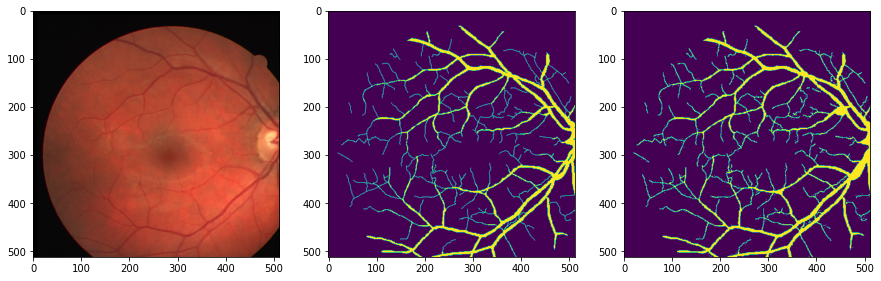

In [ ]:
figure,axis = plt.subplots(1,3,figsize=(15,15))
axis[0].imshow(torch.reshape(dataset[0]['image'],(512,512,3)))
axis[1].imshow((inference_label[0][0].cpu()))
axis[2].imshow((inference_outputs[0][0].cpu()))